In [1]:
import matplotlib.pyplot as plt
import equinox as eqx
import optax
import jax.numpy as jnp
import jax
import jax.random as jr
from functools import partial
from tqdm.auto import tqdm
from typing import Tuple, List, Dict, Any, Callable, NamedTuple
import dataclasses
from models.transformer import Transformer
from datasets.parity import Parity
from jax_tqdm import scan_tqdm
from models.mlp import MLP
import numpy as np

In [ ]:
cache = {}
def jit_code_cached(f):
    def wrapped_f(*args, **kwargs):
        ref = f.__code__
        if ref not in cache:
            print("compiling")
            cache[ref] = jax.jit(f)
        return cache[ref](*args, **kwargs)
    return wrapped_f

class gax:
    def __init__(self, kwargs, default_kwargs):
        num_vmaps = jax.tree.map(gax._check_axis, kwargs, default_kwargs)
        axes = []

        for path, num in jax.tree.leaves_with_path(num_vmaps):
            axis = jax.tree.map_with_path(lambda _path, leaf: 0 if _path == path else None,num_vmaps)
            axes.extend((axis,)*num)
        
        self.axes = axes

    @staticmethod
    def _check_axis(leaf, ref_leaf):
        if isinstance(leaf, jax.typing.ArrayLike):
            diff = len(np.shape(leaf)) - len(np.shape(ref_leaf))
            if diff > 0:
                return diff
        return None
    
    def wrap(self, func, args):
        if type(args) == dict:
          def out_f(kwargs):
              return func(**kwargs)
        else:
          def out_f(kwargs):
              return func(*kwargs)
        for axis in self.axes:
            out_f = jax.vmap(out_f, in_axes=[axis])
        return out_f(args)
    
    def apply(self, func, axis=1):
        for _ in range(len(self.axes)):
            func = jax.vmap(func, in_axes=axis)
        return func



In [3]:
# @partial(jax.vmap, in_axes=(None, None, 0))
def _init(model_args, optimizer_args):
    model = Transformer(**model_args)
    
    optimizer = optax.adamw(**optimizer_args)  # LR will be set per-model
    opt_state = optimizer.init(model)
    # model = eqx.partition(model, eqx.is_array)
    return model, (opt_state, optimizer_args)
optimizer_args = {"learning_rate":jnp.geomspace(1e-2, 1e-3, 5)}
args = [{"num_heads":8, "embd_dim":256, "qkv_dim":256, "mlp_dim":1024}, optimizer_args]
default_args = [{"num_heads":8, "embd_dim":256, "qkv_dim":256, "mlp_dim":1024}, {"learning_rate":1e-2}]
test = gax(args, default_args)
models, opt_state = test.wrap(_init, args)


def compute_metrics(logits, labels, loss):
    """Compute accuracy and loss from predictions"""
    preds = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(preds == labels)
    return {'accuracy': accuracy, 'loss': loss}


In [ ]:
def train(model_args, optimizer_args, dataset_args, train_config):
    num_steps = train_config.num_steps
    rng_key = train_config.rng_key
    rng_key, test_key = jr.split(rng_key)
    dataset = train_config.dataset(**dataset_args)
    test_data = dataset.create_batch(test_key, 256)

    if train_config.trainset_size == -1:
        @jax.jit
        def get_data(key):
            return dataset.create_batches(key, train_config.batch_size, train_config.num_seeds)
    else:
        rng_key, data_key = jr.split(rng_key)
        offline_data = dataset.create_batches(data_key, train_config.trainset_size, train_config.num_seeds)
        @jax.vmap
        def _get_data(key, _offline_dataset):
            inds = jax.random.randint(key, (train_config.batch_size), 0, train_config.trainset_size,)
            return _offline_dataset[0][inds],_offline_dataset[1][inds]
        @jax.jit
        def get_data(key):
            return _get_data(jr.split(key, train_config.num_seeds), offline_data)
    
    def _train_iter(model, opt_state, data, model_key):
        X, y = data
        def loss_fn(model):
            y_pred = jax.vmap(model, in_axes=(0, None))(X, model_key)
            return train_config.criterion(y_pred, y), y_pred 
        (loss, y_pred), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model)
        metrics = compute_metrics(y_pred, y, loss)
        updates, new_opt_state = optax.adamw(**opt_state[1]).update(grads, opt_state[0], eqx.filter(model, eqx.is_array))
        model = eqx.apply_updates(model, updates)
        return model, (new_opt_state, opt_state[1]), metrics
    model_args["key"] = jr.PRNGKey(0)
    init_args = [model_args, optimizer_args]
    default_args = [{"num_heads":8, "embd_dim":256, "qkv_dim":256, "mlp_dim":1024, "key":jr.PRNGKey(0)}, {"learning_rate":1e-2}]
    rng_key, init_key = jr.split(rng_key)
    init_keys = jr.split(init_key, train_config.num_seeds)
        
    # default_params = model.default_args()
    gax_instance = gax(init_args, default_args)
    @jax.vmap
    def init(key):
        # parallel_args = [{"num_heads":8//4, "embd_dim":256//4, "qkv_dim":512//4, "mlp_dim":1024//4, "key":key}, {"learning_rate":jnp.geomspace(1e-2, 1e-3, 5)}]
        temp = optax.tree_utils.tree_set(model_args)
        temp["key"] = key
        parallel_args = [temp, optimizer_args]
        print(parallel_args)
        return gax_instance.wrap(_init, parallel_args)
        # return _init(*[{"num_heads":8//4, "embd_dim":256//8, "qkv_dim":256//8, "mlp_dim":1024//8, "key":key}, {"learning_rate":1e-2}])
         
    models, optimizer_states = init(init_keys)
    print(model_args)
    # models, optimizer_states = init(init_keys)
    
    train_iter = jit_code_cached(jax.vmap(gax_instance.apply(_train_iter, axis=(0,0,None,None))))

    
    
    # train_iter = partial(train_iter, apply=apply)
    # models, optimizer_states, model_axes, optimizer_axes = jax.vmap(init_models, in_axes=(None, 0))(model_args, init_keys)
    # axes = jax.tree.map(lambda x: eqx.Partial(x) if callable(x) else x, axes)
    # print(axes)
    metrics_history = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }

    
    pbar = tqdm(range(num_steps))
    
    for step in pbar:
        # Create training batches
        rng_key, batch_key, train_key = jr.split(rng_key, 3)
        
        # data = get_data(batch_key)
        # Training step - returns models, opt_states, and train_metrics
        # models, optimizer_states, train_metrics = train_step(
        #     models, optimizer_states, data, train_config.model_config.optimizer_kwargs.learning_rate, train_config.model_config.criterion, train_key, train_config.num_seeds
        # ) 
        # print(config.model_config)
        train_key = jr.split(train_key, train_config.num_seeds)

        data = get_data(batch_key)
        models, optimizer_states, train_metrics = train_iter(
            models, 
            optimizer_states,
            data,
            train_key
        )
        
        # Extract train metrics (shape: [num_seeds, num_lrs])
        train_acc = jnp.array(train_metrics['accuracy'])
        train_loss = jnp.array(train_metrics['loss'])
        
        # Record best metrics: mean across seeds, then min loss / max accuracy across LRs
        metrics_history['train_loss'].append(train_loss.mean(axis=0).min())
        metrics_history['train_accuracy'].append(train_acc.mean(axis=0).max())
        
        if step % 50 == 0:
            # Eval step - returns test_metrics
            test_metrics = eval_step(models, test_data, train_config.criterion)
            # Extract test metrics (shape: [num_seeds, num_lrs])
            test_acc = jnp.array(test_metrics['accuracy'])
            test_loss = jnp.array(test_metrics['loss'])
            # Record best metrics
            metrics_history['test_loss'].append(test_loss.mean(axis=0).min())
            metrics_history['test_accuracy'].append(test_acc.mean(axis=0).max())
            pbar.set_postfix(train_acc=f"{metrics_history['train_accuracy'][-1]:.2f}", test_acc=f"{metrics_history['test_accuracy'][-1]:.2f}")
    return metrics_history

In [4]:
def train(model_args, optimizer_args, dataset_args, train_config):
    num_steps = train_config.num_steps
    rng_key = train_config.rng_key
    rng_key, test_key = jr.split(rng_key)
    dataset = train_config.dataset(**dataset_args)
    test_data = dataset.create_batch(test_key, 256)

    if train_config.trainset_size == -1:
        @jax.jit
        def get_data(key):
            return dataset.create_batches(key, train_config.batch_size, train_config.num_seeds)
    else:
        rng_key, data_key = jr.split(rng_key)
        offline_data = dataset.create_batches(data_key, train_config.trainset_size, train_config.num_seeds)
        @jax.vmap
        def _get_data(key, _offline_dataset):
            inds = jax.random.randint(key, (train_config.batch_size), 0, train_config.trainset_size,)
            return _offline_dataset[0][inds],_offline_dataset[1][inds]
        @jax.jit
        def get_data(key):
            return _get_data(jr.split(key, train_config.num_seeds), offline_data)
    
    def _train_iter(model, opt_state, data, model_key):
        X, y = data
        def loss_fn(model):
            y_pred = jax.vmap(model, in_axes=(0, None))(X, model_key)
            return train_config.criterion(y_pred, y), y_pred 
        (loss, y_pred), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model)
        metrics = compute_metrics(y_pred, y, loss)
        updates, new_opt_state = optax.adamw(**opt_state[1]).update(grads, opt_state[0], eqx.filter(model, eqx.is_array))
        model = eqx.apply_updates(model, updates)
        return model, (new_opt_state, opt_state[1]), metrics
    model_args["key"] = jr.PRNGKey(0)
    init_args = [model_args, optimizer_args]
    default_args = [{"num_heads":8, "embd_dim":256, "qkv_dim":256, "mlp_dim":1024, "key":jr.PRNGKey(0)}, {"learning_rate":1e-2}]
    rng_key, init_key = jr.split(rng_key)
    init_keys = jr.split(init_key, train_config.num_seeds)
        
    # default_params = model.default_args()
    gax_instance = gax(init_args, default_args)
    @jax.vmap
    def init(key):
        # parallel_args = [{"num_heads":8//4, "embd_dim":256//4, "qkv_dim":512//4, "mlp_dim":1024//4, "key":key}, {"learning_rate":jnp.geomspace(1e-2, 1e-3, 5)}]
        temp = optax.tree_utils.tree_set(model_args)
        temp["key"] = key
        parallel_args = [temp, optimizer_args]
        print(parallel_args)
        return gax_instance.wrap(_init, parallel_args)
        # return _init(*[{"num_heads":8//4, "embd_dim":256//8, "qkv_dim":256//8, "mlp_dim":1024//8, "key":key}, {"learning_rate":1e-2}])
         
    models, optimizer_states = init(init_keys)
    print(model_args)
    # models, optimizer_states = init(init_keys)
    
    train_iter = jit_code_cached(jax.vmap(gax_instance.apply(_train_iter, axis=(0,0,None,None))))

    
    
    # train_iter = partial(train_iter, apply=apply)
    # models, optimizer_states, model_axes, optimizer_axes = jax.vmap(init_models, in_axes=(None, 0))(model_args, init_keys)
    # axes = jax.tree.map(lambda x: eqx.Partial(x) if callable(x) else x, axes)
    # print(axes)
    metrics_history = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }

    
    pbar = tqdm(range(num_steps))
    
    for step in pbar:
        # Create training batches
        rng_key, batch_key, train_key = jr.split(rng_key, 3)
        
        # data = get_data(batch_key)
        # Training step - returns models, opt_states, and train_metrics
        # models, optimizer_states, train_metrics = train_step(
        #     models, optimizer_states, data, train_config.model_config.optimizer_kwargs.learning_rate, train_config.model_config.criterion, train_key, train_config.num_seeds
        # ) 
        # print(config.model_config)
        train_key = jr.split(train_key, train_config.num_seeds)

        data = get_data(batch_key)
        models, optimizer_states, train_metrics = train_iter(
            models, 
            optimizer_states,
            data,
            train_key
        )
        
        # Extract train metrics (shape: [num_seeds, num_lrs])
        train_acc = jnp.array(train_metrics['accuracy'])
        train_loss = jnp.array(train_metrics['loss'])
        
        # Record best metrics: mean across seeds, then min loss / max accuracy across LRs
        metrics_history['train_loss'].append(train_loss.mean(axis=0).min())
        metrics_history['train_accuracy'].append(train_acc.mean(axis=0).max())
        
        # if step % 50 == 0:
        #     # Eval step - returns test_metrics
        #     test_metrics = eval_step(models, test_data, train_config.criterion)
        #     # Extract test metrics (shape: [num_seeds, num_lrs])
        #     test_acc = jnp.array(test_metrics['accuracy'])
        #     test_loss = jnp.array(test_metrics['loss'])
        #     # Record best metrics
        #     metrics_history['test_loss'].append(test_loss.mean(axis=0).min())
        #     metrics_history['test_accuracy'].append(test_acc.mean(axis=0).max())
        #     pbar.set_postfix(train_acc=f"{metrics_history['train_accuracy'][-1]:.2f}", test_acc=f"{metrics_history['test_accuracy'][-1]:.2f}")
    return metrics_history

In [6]:
class TrainConfig(NamedTuple):
    # model: type
    dataset: type = Parity
    # model_config: Any = None
    optimizer: Callable = jax.tree_util.Partial(optax.adamw)
    # optimizer_config: Any = None
    num_steps: int = 1000
    rng_key: jax.Array = jr.PRNGKey(0)
    batch_size: int = 32
    trainset_size: int = -1 # -1 for online dataset
    # dataset_config: Any = None
    criterion: Callable = lambda y_pred, y: optax.softmax_cross_entropy_with_integer_labels(y_pred, y).mean()
    num_seeds: int = 1

model_args = {"num_heads":8, "embd_dim":256, "qkv_dim":256, "mlp_dim":1024}
optimizer_args = {"learning_rate":jnp.geomspace(1e-2, 1e-3, 10)}
dataset_args = {"d":20, "k":6, "zero_one":True}
metrics = train(model_args, optimizer_args, dataset_args, TrainConfig())

metrics = train(model_args, optimizer_args, dataset_args, TrainConfig(trainset_size=5000))

[{'embd_dim': 256, 'key': VmapTracer<uint32[2]>, 'mlp_dim': 1024, 'num_heads': 8, 'qkv_dim': 256}, {'learning_rate': Array([0.01      , 0.00774264, 0.00599484, 0.00464159, 0.00359381,
       0.00278256, 0.00215444, 0.0016681 , 0.00129155, 0.001     ],      dtype=float32)}]
{'num_heads': 8, 'embd_dim': 256, 'qkv_dim': 256, 'mlp_dim': 1024, 'key': Array([0, 0], dtype=uint32)}


  0%|          | 0/1000 [00:00<?, ?it/s]

[{'embd_dim': 256, 'key': VmapTracer<uint32[2]>, 'mlp_dim': 1024, 'num_heads': 8, 'qkv_dim': 256}, {'learning_rate': Array([0.01      , 0.00774264, 0.00599484, 0.00464159, 0.00359381,
       0.00278256, 0.00215444, 0.0016681 , 0.00129155, 0.001     ],      dtype=float32)}]
{'num_heads': 8, 'embd_dim': 256, 'qkv_dim': 256, 'mlp_dim': 1024, 'key': Array([0, 0], dtype=uint32)}


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
cache = {}
def jit_code_cached(f):
    def wrapped_f(*args, **kwargs):
        if f.__code__ not in cache:
            print("compiling")
            cache[f.__code__] = jax.jit(f)
        return cache[f.__code__](*args, **kwargs)
    return wrapped_f


cache = {}
def _check_axis(leaf, ref_leaf):
    if isinstance(leaf, jax.typing.ArrayLike):
        diff = len(np.shape(leaf)) - len(np.shape(ref_leaf))
        if diff > 0:
            return diff
    return None

def create_axes(args, default_args):
    num_vmaps = jax.tree.map(_check_axis, args, default_args)
    axes = []

    for path, num in jax.tree.leaves_with_path(num_vmaps):
        axis = jax.tree.map_with_path(lambda _path, leaf: 0 if _path == path else None,num_vmaps)
        axes.extend((axis,)*num)
    return axes

def count_axes(args, default_args):
    return len(create_axes(args, default_args))

def wrap(func, args, default_args):
    axes = create_axes(args, default_args)
    
    # create = lambda kwargs: func(*kwargs)
    def create(kwargs):
        return func(*kwargs)
    for axis in axes:
        create = jax.vmap(create, in_axes=[axis])
    # print(args)
    # print(create.__code__)
    # print(create.__code__ in cache)
    # create = jax.jit(create)
    # create = jit_code_cached(create)
    output = create(args)
    axes = axes
    # def _apply(f, axis=1):
    #     wrapped_f = f
    #     # print(f.__code__)
    #     # print("compiling")
    #     # def wrapped_f(parallel_kwargs, kwargs):
    #     #     if parallel_kwargs is None:
    #     #         if kwargs is None:
    #     #             return f()
    #     #         else:
    #     #             return f(**kwargs)
    #     #     elif kwargs is None:
    #     #         return f(**parallel_kwargs)
    #     #     else:
    #     #         return f(**parallel_kwargs, **kwargs)
    #     #     # print(parallel_kwargs, args, kwargs)
    #     #     # if parallel_args is None and args is None:
    #     #     #     return f(**parallel_kwargs, **kwargs)
    #     #     # elif parallel_args is None:
    #     #     #     return f(*args, **parallel_kwargs, **kwargs)
    #     #     # elif parallel_kwargs is None:
    #     #     #     return f(*parallel_args, *args, **kwargs)
    #     #     # else:
    #     #     #     return f(*parallel_args, *args, **parallel_kwargs, **kwargs)
        
    #     for _ in axes:
    #         wrapped_f = jax.vmap(wrapped_f, in_axes=axis)
    #     # wrapped_f = jax.jit(wrapped_f)
    #     return eqx.Partial(wrapped_f)
    #         cache[('apply', len(axes),f.__code__)] = wrapped_f
    # return cache[('apply', len(axes),f.__code__)]
    return output

def apply(f, n, axis=1):
    for _ in range(n):
        f = jax.vmap(f, in_axes=axis)
    return f
def _MLP(*args, **kwargs):
    return MLP(*args, **kwargs)
def check(n):
    def init_optimizer(model, lr):
        return optax.adamw(lr).init(model)
    
    
    def test(model, data, keys):
        return jax.vmap(model, in_axes=(0, None))(data, keys)
    dataset_config = Parity.config(d=20, k=6, zero_one=False)
    model, apply = wrap(_MLP, MLP.config(in_dim=20, layer_init_scale=[jnp.arange(5), n,1.]),  MLP.config())

    init = apply(init_optimizer)
    init({'model':model}, {'lr':1.0})
    # dataset = Parity(dataset_config)
    # keys = jr.split(jr.PRNGKey(0), 5)
    # data = dataset.create_batch(jr.PRNGKey(0), 1)[0]
    # p_test = apply(test)
    # # p_test = apply(test)
    # # print(p_test.__code__)
    # p_test((model,),None, data, keys)
    # p_test((model,),None, data, keys)
    # p_test = apply(test)

    # p_test((model,),None, data, keys)
# check(1.)
# check(2.)

In [ ]:



class wrapper():
    obj: Any
    axes: Any

    def __init__(self, obj, args, default_args):
        num_vmaps = jax.tree.map(self._check_axis, args, default_args)
        axes = []

        for path, num in jax.tree.leaves_with_path(num_vmaps):
            axis = jax.tree.map_with_path(lambda _path, leaf: 0 if _path == path else None,num_vmaps)
            axes.extend([axis]*num)
        
        create = lambda kwargs: obj(*kwargs)
        for axis in axes:
            create = jax.vmap(create, in_axes=[axis])
        # print(args)
        self.obj = create(args)
        self.axes = axes
        self.cache = {}

    @staticmethod
    def _check_axis(leaf, ref_leaf):
        if isinstance(leaf, jax.typing.ArrayLike):
            diff = len(jnp.shape(leaf)) - len(jnp.shape(ref_leaf))
            if diff > 0:
                return diff
        return None

    def apply(self, f, parallel_kwargs=None, **kwargs):
        if f not in self.cache:
            axis = {}
            for key in parallel_kwargs:
                axis[key] = 0
                for key in kwargs:
                    axis[key] = None
            
            def wrapped_f(obj, parallel_args, args):
                return f(obj, **parallel_args, **args)

            for axis in self.axes:
                wrapped_f = jax.vmap(wrapped_f, in_axes=[0, 0, None])
            
            self.cache[f] = jax.jit(wrapped_f)
        return self.cache[f](self.obj, parallel_kwargs, kwargs)
    
def test(model, data, keys):
    return jax.vmap(model, in_axes=(0, None))(data, keys)
dataset_config = Parity.config(d=20, k=6, zero_one=False)
temp = wrapper(MLP, MLP.config(in_dim=20, layer_init_scale=[jnp.arange(5), 1.,1.]),  MLP.config())
dataset = Parity(dataset_config)
keys = jr.split(jr.PRNGKey(0), 5)
data = dataset.create_batch(jr.PRNGKey(0), 1)[0]


In [2]:
class TrainConfig(NamedTuple):
    # criterion: Callable
    model: type
    dataset: type
    model_config: Any = None
    optimizer: Callable = jax.tree_util.Partial(optax.adamw)
    optimizer_config: Any = None
    num_steps: int = 1000
    rng_key: jax.Array = jr.PRNGKey(0)
    batch_size: int = 32
    trainset_size: int = -1 # -1 for online dataset
    dataset_config: Any = None
    num_seeds: int = 10
    # criterion: Callable = lambda y_pred, y: optax.softmax_cross_entropy_with_integer_labels(y_pred, y).mean()


def compute_metrics(logits, labels, loss):
    """Compute accuracy and loss from predictions"""
    preds = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(preds == labels)
    return {'accuracy': accuracy, 'loss': loss}

@jax.jit
def init_model(config: TrainConfig, key):
    """Initialize models and optimizers for all seeds and learning rates"""
    if config.model_config is None:
        config.model_config = config.model.config()
    
    # Split keys for each seed
    keys = jr.split(key, config.num_seeds)
    
    def init_single_seed(seed_key):
        """Initialize models for all learning rates for one seed"""
        lr_keys = jr.split(seed_key, len(config.lrs))
        
        def init_single_model(model_key):
            model = config.model(config.model_config, model_key)

            optimizer = optax.adamw(1.0)  # LR will be set per-model
            opt_state = optimizer.init(model)
            # model = eqx.partition(model, eqx.is_array)
            return model, opt_state
        
        # Vmap over learning rates
        models, opt_states = jax.vmap(init_single_model)(lr_keys)
        return models, opt_states
    
    # Vmap over seeds
    models, opt_states = jax.vmap(init_single_seed)(keys)
    return models, opt_states

In [ ]:
def train(train_config: TrainConfig):
    num_steps = train_config.num_steps
    rng_key = train_config.rng_key
    rng_key, test_key = jr.split(rng_key)
    dataset = train_config.dataset(train_config.dataset_config)
    test_data = dataset.create_batch(test_key, 256)

    if train_config.trainset_size == -1:
        @jax.jit
        def get_data(key):
            return dataset.create_batches(key, train_config.batch_size, train_config.num_seeds)
    else:
        rng_key, data_key = jr.split(rng_key)
        offline_data = dataset.create_batches(data_key, train_config.trainset_size, train_config.num_seeds)
        @jax.vmap
        def _get_data(key, _offline_dataset):
            inds = jax.random.randint(key, (train_config.batch_size), 0, train_config.trainset_size,)
            return _offline_dataset[0][inds],_offline_dataset[1][inds]
        @jax.jit
        def get_data(key):
            return _get_data(jr.split(key, train_config.num_seeds), offline_data)
    
    rng_key, init_key = jr.split(rng_key)
    init_keys = jr.split(init_key, train_config.num_seeds)
    models, optimizer_states, model_axes, optimizer_axes = jax.vmap(init_models, in_axes=(None, 0))(train_config, init_keys)
    # axes = jax.tree.map(lambda x: eqx.Partial(x) if callable(x) else x, axes)
    # print(axes)
    metrics_history = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }

    
    @jax.jit
    def train_iter(model, opt_state, data, model_key):
        X, y = data
        def loss_fn(model):
            y_pred = eqx.filter_vmap(model, in_axes=(0, None))(X, model_key)
            return criterion(y_pred, y), y_pred 
        (loss, y_pred), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model)
        metrics = compute_metrics(y_pred, y, loss)

        updates, opt_state = optax.adamw(0.01).update(grads, opt_state, eqx.filter(model, eqx.is_array))
        model = eqx.apply_updates(model, updates)
        return model, opt_state, metrics
    # nested_vmap(train_iter, len(optimizer_axes)+len(model_axes), (0, 0, None, None))
    for axis in range(len(optimizer_axes)+len(model_axes)):
        train_iter = jax.vmap(train_iter, in_axes=(0, 0, None, None))
    train_iter = jax.vmap(train_iter, in_axes=(0, 0, 0, 0))
    criterion = train_config.model_config.criterion
    train_iter = jax.jit(train_iter)
    # for axis in axes:
    #     f = jax.vmap(f, in_axes=(0, 0,None, None, None))
    # optimizer, criterion = train_config.model_config.optimizer, train_config.model_config.criterion
    # @eqx.filter_jit
    # @partial(jax.vmap, in_axes=(0,0,0, None))
    # def train_iter(models, opt_states, data, key):
    #     return f(models, opt_states, data, key, criterion)
    pbar = tqdm(range(num_steps))
    
    for step in pbar:
        # Create training batches
        rng_key, batch_key, train_key = jr.split(rng_key, 3)
        
        data = get_data(batch_key)
        # Training step - returns models, opt_states, and train_metrics
        # models, optimizer_states, train_metrics = train_step(
        #     models, optimizer_states, data, train_config.model_config.optimizer_kwargs.learning_rate, train_config.model_config.criterion, train_key, train_config.num_seeds
        # ) 
        # print(config.model_config)
        train_key = jr.split(train_key, train_config.num_seeds)
        models, optimizer_states, train_metrics = train_iter(
            models, optimizer_states, data, train_key
        )
        
        # Extract train metrics (shape: [num_seeds, num_lrs])
        train_acc = jnp.array(train_metrics['accuracy'])
        train_loss = jnp.array(train_metrics['loss'])
        
        # Record best metrics: mean across seeds, then min loss / max accuracy across LRs
        metrics_history['train_loss'].append(train_loss.mean(axis=0).min())
        metrics_history['train_accuracy'].append(train_acc.mean(axis=0).max())
        
        # if step % 50 == 0:
        #     # Eval step - returns test_metrics
        #     test_metrics = eval_step(models, test_data, train_config.criterion)
        #     # Extract test metrics (shape: [num_seeds, num_lrs])
        #     test_acc = jnp.array(test_metrics['accuracy'])
        #     test_loss = jnp.array(test_metrics['loss'])
        #     # Record best metrics
        #     metrics_history['test_loss'].append(test_loss.mean(axis=0).min())
        #     metrics_history['test_accuracy'].append(test_acc.mean(axis=0).max())
        #     pbar.set_postfix(train_acc=f"{metrics_history['train_accuracy'][-1]:.2f}", test_acc=f"{metrics_history['test_accuracy'][-1]:.2f}")
    return metrics_history

In [ ]:
def _check_axis(leaf, ref_leaf):
    
    if isinstance(leaf, jax.typing.ArrayLike):
        diff = len(jnp.shape(leaf)) - len(jnp.shape(ref_leaf))
        if diff > 0:
            return diff
    return None

def create_axes(config, default_config):
    num_vmaps = jax.tree.map(_check_axis, config, default_config)

    axes = []

    for path, num in jax.tree.leaves_with_path(num_vmaps):
        axis = jax.tree.map_with_path(lambda _path, leaf: 0 if _path == path else None,num_vmaps)
        axes.extend([axis]*num)
    return axes


def init_models(config, key):
    model_axes = create_axes(config.model_config, config.model.config())
    optimizer_axes = create_axes(config.optimizer_config, config.model.optimizer_config())
    
    
    def _init_model_and_opt_state(model_config, optimizer_config):
        model = config.model(model_config)
        opt_state = config.optimizer(*optimizer_config).init(model)
        return model, opt_state, #config.optimizer_kwargs
    init_f = _init_model_and_opt_state
    for axis in model_axes:
        init_f = jax.vmap(init_f, in_axes=[axis, None])
    for axis in optimizer_axes:
        init_f = jax.vmap(init_f, in_axes=[None, axis])
    return *init_f(config.model_config, config.optimizer_config), model_axes, optimizer_axes


# class model_wrapper():
#     models: eqx.Module
#     axes: Any
#     config: Any
#     opt_state: jax.Array
#     def __init__(self, config, key):
#         num_vmaps = jax.tree.map(self._check_axis, config.model_config, config.model.config())

#         axes = []

#         for path, num in jax.tree.leaves_with_path(num_vmaps):
#             axis = jax.tree.map_with_path(lambda _path, leaf: 0 if _path == path else None,num_vmaps)
#             axes.extend([axis]*num)
        
#         self.axes = axes
#         self.config = config
#         init_f = self._init_model_and_opt_state
#         for axis in axes:
#             init_f = jax.vmap(init_f, in_axes=[axis])
#         self.models, self.opt_state = init_f(config.model_config)


#     def __call__(self, *args, **kwargs):
#         return self.models(*args, **kwargs)
    
#     # def vmap(self, f, other_in_axes=tuple(), out_axes=None):
#     #     for axis in self.axes:
#     #         f = jax.vmap(f, in_axes=[axis, *other_in_axes], out_axes=out_axes)
#     #     return f
#     # @eqx.filter_jit
#     def train_iter(self, data, key):
#         def _train_iter(model, opt_state):
#             X, y = data
#             def loss_fn(model):
#                 y_pred = jax.vmap(model, in_axes=(0, None))(X, key)
#                 return self.config.model_config.criterion(y_pred, y), y_pred 
#             (loss, y_pred), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model)
#             optim = self.config.model_config.optimizer(**self.config.model_config.optimizer_kwargs)
#             updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
#             model = eqx.apply_updates(model, updates)
#             # print(loss)
#             return  opt_state, model, (loss, y_pred)
#         f = _train_iter
#         for axis in self.axes:
#             f = jax.vmap(f)
#         self.opt_state, self.models, (loss, y_pred) = f(self.models, self.opt_state)
#         return (loss, y_pred)


dataset_config = Parity.config(d=20, k=6, zero_one=True)
mlp_config = MLP.config(layer_init_scale=[1.,1,1])

# transformer_config = Transformer.config(vocab_size=2, key=jr.PRNGKey(0))
optimizer_config = Transformer.optimizer_config(learning_rate=jnp.array([1e-2]))

config = TrainConfig(
    # rng_key=jnp.array([0,1]),
    model=MLP,
    trainset_size = -1,
    dataset=Parity,
    dataset_config=dataset_config,
    model_config=mlp_config,
    optimizer_config = optimizer_config,
    num_seeds=10)
# b = model_wrapper(config, jr.PRNGKey(0))
# # test = transformer_config.model(Transformer.config(), jr.PRNGKey(0))
# data = jax.random.randint(jr.PRNGKey(0), (10, 20), 0, 2)
# y = jax.random.randint(jr.PRNGKey(0), (10,), 0, 2)
# # data = jax.random.randint(jr.PRNGKey(0), (20), 0, 2)
# # y = jax.random.randint(jr.PRNGKey(0),1, 0, 2)[0]
# # print(transformer_config.criterion(test(data, jr.PRNGKey(0)), y))
# test = (b.train_iter((data, y),  jr.PRNGKey(0)))
# # print(test)
# test = (b.train_iter((data, y),  jr.PRNGKey(0)))
# print(test[0].shape)


In [ ]:
def train(train_config: TrainConfig):
    num_steps = train_config.num_steps
    rng_key = train_config.rng_key
    rng_key, test_key = jr.split(rng_key)
    dataset = train_config.dataset(train_config.dataset_config)
    test_data = dataset.create_batch(test_key, 256)

    if train_config.trainset_size == -1:
        @jax.jit
        def get_data(key):
            return dataset.create_batches(key, train_config.batch_size, train_config.num_seeds)
    else:
        rng_key, data_key = jr.split(rng_key)
        offline_data = dataset.create_batches(data_key, train_config.trainset_size, train_config.num_seeds)
        @jax.vmap
        def _get_data(key, _offline_dataset):
            inds = jax.random.randint(key, (train_config.batch_size), 0, train_config.trainset_size,)
            return _offline_dataset[0][inds],_offline_dataset[1][inds]
        @jax.jit
        def get_data(key):
            return _get_data(jr.split(key, train_config.num_seeds), offline_data)
    
    rng_key, init_key = jr.split(rng_key)
    models, optimizer_states = init_models(train_config, init_key)

    metrics_history = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }
    pbar = tqdm(range(num_steps))
    for step in pbar:
        # Create training batches
        rng_key, batch_key, train_key = jr.split(rng_key, 3)
        
        data = get_data(batch_key)
        # Training step - returns models, opt_states, and train_metrics
        models, optimizer_states, train_metrics = train_step(
            models, optimizer_states, data, train_config.lrs, train_config.criterion, train_key, train_config.num_seeds
        )
        
        # Extract train metrics (shape: [num_seeds, num_lrs])
        train_acc = jnp.array(train_metrics['accuracy'])
        train_loss = jnp.array(train_metrics['loss'])
        
        # Record best metrics: mean across seeds, then min loss / max accuracy across LRs
        metrics_history['train_loss'].append(train_loss.mean(axis=0).min())
        metrics_history['train_accuracy'].append(train_acc.mean(axis=0).max())
        
        if step % 50 == 0:
            # Eval step - returns test_metrics
            test_metrics = eval_step(models, test_data, train_config.criterion)
            # Extract test metrics (shape: [num_seeds, num_lrs])
            test_acc = jnp.array(test_metrics['accuracy'])
            test_loss = jnp.array(test_metrics['loss'])
            # Record best metrics
            metrics_history['test_loss'].append(test_loss.mean(axis=0).min())
            metrics_history['test_accuracy'].append(test_acc.mean(axis=0).max())
            pbar.set_postfix(train_acc=f"{metrics_history['train_accuracy'][-1]:.2f}", test_acc=f"{metrics_history['test_accuracy'][-1]:.2f}")
    return metrics_history

In [4]:
# @eqx.filter_jit
# def _train_iter(model, opt_state, data, model_key, criterion):
#         X, y = data
#         def loss_fn(model):
#             y_pred = eqx.filter_vmap(model, in_axes=(0, None))(X, model_key)
#             return criterion(y_pred, y), y_pred 
#         (loss, y_pred), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model)
#         metrics = compute_metrics(y_pred, y, loss)
#         # optim = train_config.model_config.optimizer(*train_config.model_config.optimizer_kwargs)
#         optim = optax.adamw(0.01)
#         updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
#         model = eqx.apply_updates(model, updates)
#         # print(loss)
#         return  model, opt_state, metrics

def nested_vmap(f, n, in_axes):
    for _ in range(n):
        f = jax.vmap(f, in_axes=in_axes)
    return f


from eq_parallel import train_step
def train(train_config: TrainConfig):
    num_steps = train_config.num_steps
    rng_key = train_config.rng_key
    rng_key, test_key = jr.split(rng_key)
    dataset = train_config.dataset(train_config.dataset_config)
    test_data = dataset.create_batch(test_key, 256)

    if train_config.trainset_size == -1:
        @jax.jit
        def get_data(key):
            return dataset.create_batches(key, train_config.batch_size, train_config.num_seeds)
    else:
        rng_key, data_key = jr.split(rng_key)
        offline_data = dataset.create_batches(data_key, train_config.trainset_size, train_config.num_seeds)
        @jax.vmap
        def _get_data(key, _offline_dataset):
            inds = jax.random.randint(key, (train_config.batch_size), 0, train_config.trainset_size,)
            return _offline_dataset[0][inds],_offline_dataset[1][inds]
        @jax.jit
        def get_data(key):
            return _get_data(jr.split(key, train_config.num_seeds), offline_data)
    
    rng_key, init_key = jr.split(rng_key)
    init_keys = jr.split(init_key, train_config.num_seeds)
    models, optimizer_states, model_axes, optimizer_axes = jax.vmap(init_models, in_axes=(None, 0))(train_config, init_keys)
    # axes = jax.tree.map(lambda x: eqx.Partial(x) if callable(x) else x, axes)
    # print(axes)
    metrics_history = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }

    
    @jax.jit
    def train_iter(model, opt_state, data, model_key):
        X, y = data
        def loss_fn(model):
            y_pred = eqx.filter_vmap(model, in_axes=(0, None))(X, model_key)
            return criterion(y_pred, y), y_pred 
        (loss, y_pred), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model)
        metrics = compute_metrics(y_pred, y, loss)

        updates, opt_state = optax.adamw(0.01).update(grads, opt_state, eqx.filter(model, eqx.is_array))
        model = eqx.apply_updates(model, updates)
        return model, opt_state, metrics
    # nested_vmap(train_iter, len(optimizer_axes)+len(model_axes), (0, 0, None, None))
    for axis in range(len(optimizer_axes)+len(model_axes)):
        train_iter = jax.vmap(train_iter, in_axes=(0, 0, None, None))
    train_iter = jax.vmap(train_iter, in_axes=(0, 0, 0, 0))
    criterion = train_config.model_config.criterion
    train_iter = jax.jit(train_iter)
    # for axis in axes:
    #     f = jax.vmap(f, in_axes=(0, 0,None, None, None))
    # optimizer, criterion = train_config.model_config.optimizer, train_config.model_config.criterion
    # @eqx.filter_jit
    # @partial(jax.vmap, in_axes=(0,0,0, None))
    # def train_iter(models, opt_states, data, key):
    #     return f(models, opt_states, data, key, criterion)
    pbar = tqdm(range(num_steps))
    
    for step in pbar:
        # Create training batches
        rng_key, batch_key, train_key = jr.split(rng_key, 3)
        
        data = get_data(batch_key)
        # Training step - returns models, opt_states, and train_metrics
        # models, optimizer_states, train_metrics = train_step(
        #     models, optimizer_states, data, train_config.model_config.optimizer_kwargs.learning_rate, train_config.model_config.criterion, train_key, train_config.num_seeds
        # ) 
        # print(config.model_config)
        train_key = jr.split(train_key, train_config.num_seeds)
        models, optimizer_states, train_metrics = train_iter(
            models, optimizer_states, data, train_key
        )
        
        # Extract train metrics (shape: [num_seeds, num_lrs])
        train_acc = jnp.array(train_metrics['accuracy'])
        train_loss = jnp.array(train_metrics['loss'])
        
        # Record best metrics: mean across seeds, then min loss / max accuracy across LRs
        metrics_history['train_loss'].append(train_loss.mean(axis=0).min())
        metrics_history['train_accuracy'].append(train_acc.mean(axis=0).max())
        
        # if step % 50 == 0:
        #     # Eval step - returns test_metrics
        #     test_metrics = eval_step(models, test_data, train_config.criterion)
        #     # Extract test metrics (shape: [num_seeds, num_lrs])
        #     test_acc = jnp.array(test_metrics['accuracy'])
        #     test_loss = jnp.array(test_metrics['loss'])
        #     # Record best metrics
        #     metrics_history['test_loss'].append(test_loss.mean(axis=0).min())
        #     metrics_history['test_accuracy'].append(test_acc.mean(axis=0).max())
        #     pbar.set_postfix(train_acc=f"{metrics_history['train_accuracy'][-1]:.2f}", test_acc=f"{metrics_history['test_accuracy'][-1]:.2f}")
    return metrics_history

In [ ]:







# @partial(jax.jit, static_argnames=('criterion','num_seeds'))
# @eqx.filter_jit
# def gradient_step_batch(models, opt_states, data, lrs, criterion, key, num_seeds):
#     """Train step vmapped over seeds and learning rates - returns models, opt_states, and metrics"""
#     # Split keys for each seed
#     keys = jr.split(key, num_seeds)

#     @partial(jax.vmap, in_axes=(0,0,0))
#     def train_seed(model, key, data):
#         X, y = data
#         def loss_fn(model):
#             y_pred = jax.vmap(model, in_axes=(0,None))(X, key)
#             return criterion(y_pred, y), y_pred
#         # Further split keys for each LR
#         (loss, logits), grads = jax.vmap(eqx.filter_value_and_grad(loss_fn, has_aux=True))(model)
#         # Compute metrics
#         metrics = jax.vmap(compute_metrics, in_axes=(0,None,0))(logits, y, loss)
#         return grads, metrics
    
#     grads, metrics = train_seed(models, keys, data)

#     # Update model
#     # opt_state = optimizer.init(model)
#     @partial(jax.vmap, in_axes=(0,1,1,1), out_axes=1)
#     def update(lr, grads, opt_state, model):
#         updates, opt_state = jax.vmap(optax.adamw(lr).update)(
#             grads, opt_state, model
#         )
#         model = jax.vmap(eqx.apply_updates)(model, updates)
#         return model, opt_state
    
#     models, opt_states = update(lrs, grads, opt_states, models)
#     return models, opt_states, metrics
@partial(jax.jit, static_argnames=('criterion','num_seeds'))
def gradient_step_batch(models, opt_states, data, lrs, criterion, key, num_seeds):
    """Train step vmapped over seeds and learning rates - returns models, opt_states, and metrics"""
    # Split keys for each seed
    keys = jr.split(key, num_seeds)

    @partial(jax.vmap, in_axes=(0,0,0,0))
    def train_seed(models, key, data, opt_states):
        X, y = data
        def loss_fn(model):
            y_pred = jax.vmap(model, in_axes=(0,None))(X, key)
            return criterion(y_pred, y), y_pred
        # Further split keys for each LR
        (loss, logits), grads = jax.vmap(eqx.filter_value_and_grad(loss_fn, has_aux=True))(models)
        # Compute metrics
        metrics = jax.vmap(compute_metrics, in_axes=(0,None,0))(logits, y, loss)
        updates, opt_states = jax.vmap(lambda lr, grads, opt_state, model: optax.adamw(lr).update(grads, opt_state, model))(lrs, grads, opt_states, models)
        models = jax.vmap(eqx.apply_updates)(models, updates)
        return models, opt_states, metrics
    
    return train_seed(models, keys, data, opt_states)


# @partial(jax.jit, static_argnames=('criterion',))
@partial(jax.jit, static_argnames=('criterion',))
@partial(jax.vmap, in_axes=(0,None, None))
@partial(jax.vmap, in_axes=(0,None, None))
def eval_step_single(model, data, criterion):
    """Eval step for a single model - returns metrics"""
    X, y = data
    logits = jax.vmap(model, in_axes=(0,None))(X, None)
    loss = criterion(logits, y)
    metrics = compute_metrics(logits, y, loss)
    return metrics

In [8]:
# Should be fine to change things in this block


def train(train_config: TrainConfig):
    num_steps = train_config.num_steps
    rng_key = train_config.rng_key
    rng_key, test_key = jr.split(rng_key)
    dataset = train_config.dataset(train_config.dataset_config)
    test_data = dataset.create_batch(test_key, 256)

    if train_config.trainset_size == -1:
        @jax.jit
        def get_data(key):
            return dataset.create_batches(key, train_config.batch_size, train_config.num_seeds)
    else:
        rng_key, data_key = jr.split(rng_key)
        offline_data = dataset.create_batches(data_key, train_config.trainset_size, train_config.num_seeds)
        @jax.vmap
        def _get_data(key, _offline_dataset):
            inds = jax.random.randint(key, (train_config.batch_size), 0, 5000,)
            return _offline_dataset[0][inds],_offline_dataset[1][inds]
        @jax.jit
        def get_data(key):
            return _get_data(jr.split(key, train_config.num_seeds), offline_data)
    
    rng_key, init_key = jr.split(rng_key)
    models, optimizer_states = init_model(train_config, init_key)

    metrics_history = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }
    pbar = tqdm(range(num_steps))
    for step in pbar:
        # Create training batches
        rng_key, batch_key, train_key = jr.split(rng_key, 3)
        
        data = get_data(batch_key)
        # Training step - returns models, opt_states, and train_metrics
        models, optimizer_states, train_metrics = gradient_step_batch(
            models, optimizer_states, data, train_config.lrs, train_config.criterion, train_key, train_config.num_seeds
        )
        
        # Extract train metrics (shape: [num_seeds, num_lrs])
        train_acc = jnp.array(train_metrics['accuracy'])
        train_loss = jnp.array(train_metrics['loss'])
        
        # Record best metrics: mean across seeds, then min loss / max accuracy across LRs
        metrics_history['train_loss'].append(train_loss.mean(axis=0).min())
        metrics_history['train_accuracy'].append(train_acc.mean(axis=0).max())
        # test_metrics = eval_step_single(models, test_data, train_config.criterion)
        
        if step % 50 == 0:
            # Eval step - returns test_metrics
            test_metrics = eval_step_single(models, test_data, train_config.criterion)
            # Extract test metrics (shape: [num_seeds, num_lrs])
            test_acc = jnp.array(test_metrics['accuracy'])
            test_loss = jnp.array(test_metrics['loss'])
            # Record best metrics
            metrics_history['test_loss'].append(test_loss.mean(axis=0).min())
            metrics_history['test_accuracy'].append(test_acc.mean(axis=0).max())
            pbar.set_postfix(train_acc=metrics_history['train_accuracy'][-1], test_acc=metrics_history['test_accuracy'][-1])
    return metrics_history

In [ ]:
# Feel free to change the parameters in this block

dataset_config = Parity.config(d=20, k=6, dtype=jnp.int32, zero_one=True)

model_config = Transformer.config(
    vocab_size=2,
    max_len=dataset_config.d,
    embd_dim=256,
    mlp_dim=1024,
    qkv_dim=512,
    num_heads=8,
    num_layers=2,
    dtype=jnp.float32
)

# model_config = MLP.config(
#     in_dim=dataset_config.d,
#     out_dim=1,
#     hidden_dim=128,
#     hidden_layers=2,
#     layer_init_scale=jnp.ones(3)[:, None]*jnp.arange(4),
# )



config = TrainConfig(
    lrs=jnp.geomspace(1e-4, 1e-1, 50),
    num_seeds=1,
    model=Transformer,
    trainset_size = -1,
    dataset=Parity,
    dataset_config=dataset_config,
    model_config=model_config,
    num_steps = 5000,
)


In [7]:
# config.replace(trainset_size=-1)
online_metrics_history = train(config)
# offline_config = config.replace(trainset_size=5000)
offline_config = config._replace(trainset_size=5000)
offline_metrics_history = train(offline_config)

ValueError: Named tuple arity mismatch: 2 != 1; tuple: optimizer_config(learning_rate=Array(0.01, dtype=float32, weak_type=True), optimizer=<function adamw at 0x7fd98fdbcae0>).

In [27]:
def f(x):
    return [1]*x
a = jax.vmap(f)(jnp.arange(10))
# print(jnp.array([(1,2,),(2,3)]))

TypeError: unsupported operand type(s) for *: 'list' and 'BatchTracer'

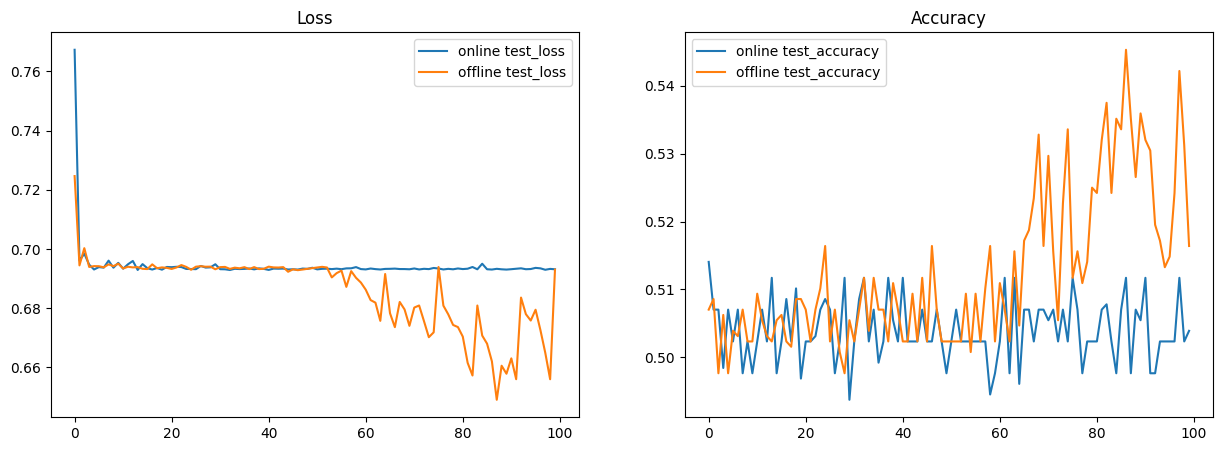

In [28]:
metrics = {"online": online_metrics_history, "offline": offline_metrics_history, }
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for metric in metrics:
    for dataset in ('test',):
        ax1.plot(metrics[metric][f'{dataset}_loss'], label=f'{metric} {dataset}_loss')
        ax2.plot(metrics[metric][f'{dataset}_accuracy'], label=f'{metric} {dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

In [9]:
path = jax.tree.leaves_with_path(test)[0][0]
print(test)
temp = test
# temp[path[0].key] = 2
# print(temp)

NameError: name 'test' is not defined

((DictKey(key='layer_init_scale'), SequenceKey(idx=0)), 0)

In [ ]:
# more complicated, not better


@partial(jax.jit, static_argnames=('criterion','num_seeds'))
def gradient_steps_batch(models, opt_states, datem, lrs, criterion, key, num_seeds):
    model_dynamic, model_static = eqx.partition(models, eqx.is_array)
    def gradient_step_scan(carry, data):
        model_dynamic, opt_states = carry
        models = eqx.combine(model_dynamic, model_static)
        models, _, metrics = gradient_step_batch(models, opt_states, data, lrs, criterion, key, num_seeds)
        model_dynamic, _ = eqx.partition(models, eqx.is_array)
        return (model_dynamic, opt_states), metrics
    # keys = jr.split(key, num_steps)
    # print(gradient_step_scan((model_dynamic, opt_states), (datem[0][0], datem[1][0])))
    return jax.lax.scan(gradient_step_scan, (model_dynamic, opt_states), datem)

def train(train_config: TrainConfig):
    num_steps = train_config.num_steps
    rng_key = train_config.rng_key
    rng_key, test_key = jr.split(rng_key)
    dataset = train_config.dataset(train_config.dataset_config)
    test_data = dataset.create_batch(test_key, 256)

    if train_config.trainset_size == -1:
        @jax.jit
        def get_data(key):
            return dataset.create_batches(key, train_config.batch_size, train_config.num_seeds)
    else:
        rng_key, data_key = jr.split(rng_key)
        offline_data = dataset.create_batches(data_key, train_config.trainset_size, train_config.num_seeds)
        @jax.vmap
        def _get_data(key, _offline_dataset):
            inds = jax.random.randint(key, (train_config.batch_size), 0, 5000,)
            return _offline_dataset[0][inds],_offline_dataset[1][inds]
        @jax.jit
        @jax.vmap
        def get_data(key):
            return _get_data(jr.split(key, train_config.num_seeds), offline_data)
    
    rng_key, init_key = jr.split(rng_key)
    models, optimizer_states = init_model(train_config, init_key)

    metrics_history = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }
    pbar = tqdm(range(num_steps//50))
    for step in pbar:
        # Create training batches
        rng_key, batch_key, train_key = jr.split(rng_key, 3)
        batch_key = jr.split(batch_key, 50)
        datem = get_data(batch_key)
        # Training step - returns models, opt_states, and train_metrics
        (models, optimizer_states), train_metrics = train_steps_batch(
            models, optimizer_states, datem, train_config.lrs, train_config.criterion, train_key, train_config.num_seeds
        )
        
        # Extract train metrics (shape: [num_seeds, num_lrs])
        train_acc = jnp.array(train_metrics['accuracy'])
        train_loss = jnp.array(train_metrics['loss'])
        # Record best metrics: mean across seeds, then min loss / max accuracy across LRs
        metrics_history['train_loss'].extend(train_loss.mean(axis=-2).min(axis=-1))
        metrics_history['train_accuracy'].extend(train_acc.mean(axis=-2).max(axis=-1))
        
        if step % 50 == 0:
            # Eval step - returns test_metrics
            test_metrics = eval_step_batch(models, test_data, train_config.criterion)
            
            # Extract test metrics (shape: [num_seeds, num_lrs])
            test_acc = jnp.array(test_metrics['accuracy'])
            test_loss = jnp.array(test_metrics['loss'])
            
            # Record best metrics
            metrics_history['test_loss'].append(test_loss.mean(axis=0).min())
            metrics_history['test_accuracy'].append(test_acc.mean(axis=0).max())
        
        if step % 10 == 0:
            # print(f"Step {step}: Train acc={metrics_history['train_accuracy'][-1]:.4f}, "
            #         f"Test acc={metrics_history['test_accuracy'][-1]:.4f}")
            pbar.set_postfix(train_acc=metrics_history['train_accuracy'][-1], test_acc=metrics_history['test_accuracy'][-1])
    return metrics_history

In [ ]:
# more complicated, not better


def train(train_config: TrainConfig):
    num_steps = train_config.num_steps
    rng_key = train_config.rng_key
    rng_key, test_key = jr.split(rng_key)
    dataset = train_config.dataset(train_config.dataset_config)
    test_data = dataset.create_batch(test_key, 256)
    if train_config.trainset_size == -1:
        @jax.jit
        @jax.vmap
        def get_data(key):
            return dataset.create_batches(key, train_config.batch_size, train_config.num_seeds)
    else:
        rng_key, data_key = jr.split(rng_key)
        offline_data = dataset.create_batches(data_key, train_config.trainset_size, train_config.num_seeds)
        @jax.vmap
        def _get_data(key, _offline_dataset):
            inds = jax.random.randint(key, (train_config.batch_size), 0, 5000,)
            return _offline_dataset[0][inds],_offline_dataset[1][inds]
        @jax.jit
        def get_data(key):
            return _get_data(jr.split(key, train_config.num_seeds), offline_data)
    
        
    rng_key, init_key = jr.split(rng_key)
    models, optimizer_states = init_model(train_config, init_key)

    
    model_dynamic, model_static = eqx.partition(models, eqx.is_array)
    opt_dynamic, opt_static = eqx.partition(optimizer_states, eqx.is_array)
    @jax.jit
    @scan_tqdm(train_config.num_steps, print_rate=5)
    def train_step(carry, x):
        _, key = x
        model_dynamic, opt_dynamic = carry
        opt_state = eqx.combine(opt_dynamic, opt_static)
        models = eqx.combine(model_dynamic, model_static)
        data_key, train_key = jr.split(key)
        data = get_data(data_key)
        # train_key = jr.split(train_key, train_config.num_seeds)

        # keys = jr.split(key, train_config.num_seeds)
        models, opt_dynamic, train_metrics = gradient_step_batch(
            models, opt_state, data, train_config.lrs, train_config.criterion, train_key, train_config.num_seeds
        )
        test_metrics = eval_step_batch(models, test_data, train_config.criterion)
        opt_dynamic, _ = eqx.partition(opt_state, eqx.is_array)
        
        model_dynamic, _ = eqx.partition(models, eqx.is_array)
        return (model_dynamic, opt_dynamic), (train_metrics, test_metrics)
    keys = jr.split(rng_key, num_steps)
    (models, optimizer_states), (train_metrics, test_metrics) = jax.lax.scan(train_step, (model_dynamic, optimizer_states), (jnp.arange(train_config.num_steps), keys))
    metrics_history = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }
    
    return (train_metrics, test_metrics)
